In [804]:
# If ipytest isn't installed in your environment, run:
# %pip install -q ipytest pytest
# %pip install matplotlib

## configuration

In [805]:
from numpy.f2py.crackfortran import word_pattern

# "Księga [numer księgi]"
CHAPTER_TITLE_REGEX_PL = r'^\s*Księga\s+(\w+|[IVXLCDM\d]+)\s*$'

DEFAULT_CONFIG_PL = {
    'top_longest_words_number': 10,
    'top_most_common_words_number': 10,
    'ignored_words': [
        'i', 'a', 'że', 'lub', "w", "się", "z", "na", "nie", "jak", "do", "to", "o", "za",
        "po", "co", "od", "lecz", "bo", "gdy", "ja",
    ],
    'ignored_intro_lines': [
        'Adam Mickiewicz',
        'Pan Tadeusz',
        'czyli ostatni zajazd na Litwie',
        'ISBN 978-83-288-2495-9'
    ],
    'ignored_regexps': [
        r'^.*?ISBN\s+978-83-\d{3}-\d{4}-\d{1,2}\s*',
        CHAPTER_TITLE_REGEX_PL
    ]
}

# dla testowego pliku z teksrami piosenek [Chorus] [Verse 1] etc
LYRICS_TAGS_REGEX = r'\[.*?\]'

DEFAULT_CONFIG_EN = {
    'top_longest_words_number': 10,
    'top_most_common_words_number': 10,
    'ignored_intro_lines': [],
    'ignored_words': ['a', 'the', 'do'],
    'ignored_regexps': [
        LYRICS_TAGS_REGEX
    ]
}

from collections import Counter



Technical functions (file loading, handling errors, generating histogram chart etc)

In [806]:
def ensure_string(input_text):
    """Raises TypeError if input_text is not a string."""
    if not isinstance(input_text, str):
        raise TypeError(
            f"expected a string, got {type(input_text).__name__}"
        )


def load_text(filename):
    """Loads text from a file."""
    ensure_string(filename)
    if not filename.endswith(".txt"):
        raise ValueError(f"Expected a .txt file, got {filename!r} instead.")
    file = open(filename, "r", encoding="utf-8")
    text = file.read()
    file.close()

    return text

import matplotlib.pyplot as plt
from collections import Counter

def words_length_histogram(words_list):
    word_lengths = [len(s) for s in words_list]

    length_counter = Counter(word_lengths)

    sorted_lengths = sorted(length_counter.keys())
    counts = [length_counter[length] for length in sorted_lengths]

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(sorted_lengths, counts, color='skyblue', edgecolor='black')

    ax.set_xlabel('Długość słowa', fontsize=14)
    ax.set_ylabel('Częstotliwość', fontsize=14)
    ax.set_title('Histogram Długości Słów', fontsize=16)

    ax.set_xticks(sorted_lengths)

    for length, count in zip(sorted_lengths, counts):
        ax.text(length, count + 0.1, str(count), ha='center', va='bottom', fontsize=10)

    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()



In [807]:
import re

def tokenize_by_regexp(input_text):
    """Tokenizes text using a regular expression to find word boundaries.
    - Converts text to lowercase.
    - Extracts word-like tokens (letters, numbers, underscores, digits).
    - Raises TypeError for non-string inputs.
    """
    ensure_string(input_text)
    return re.findall(r"\b\w+\b", input_text.lower())


In [808]:
def longest_words(input_text, n = 10):
    """returns top n longest workds in input_text
    it is using the build-in function sorted
    """
    print(n)
    ensure_string(input_text)
    all_words = tokenize_by_regexp(input_text)
    words = sorted(all_words, key=len, reverse=True)[:n]
    return words
longest_words('Ala ma kota')

10


['kota', 'ala', 'ma']

In [809]:
def most_common_words(input_text, n=10):
    """returns top n most common workds in input_text
    it is using the collections.Counter class
    """
    ensure_string(input_text)
    all_words = tokenize_by_regexp(input_text)
    word_counts = Counter(all_words)
    most_common = word_counts.most_common(n)
    return most_common

In [810]:
def cleanup_text(text, config=DEFAULT_CONFIG_PL):
    """Removes words from text."""
    flags = re.IGNORECASE | re.DOTALL | re.MULTILINE
    for regexp in config.get("ignored_regexps", []):
        text = re.sub(regexp, "", text, flags=flags)

    # remove ignored common words
    for word in config.get("ignored_words", []):
        regex = r'\b' + re.escape(word) + r'\b'
        text = re.sub(regex, '', text, flags=re.IGNORECASE)
    return text

### Pan Tadeusz - Adam Mickiewicz. Najdłuższe i najczęściej występujęce słowa

In [819]:
def ex01_imp(filename = 'pan-tadeusz.txt'):
    cleaned_text = cleanup_text(load_text(filename))
    print("Najdłuższe słowa w Panu Tadeuszu to:")

    all_words = tokenize_by_regexp(cleaned_text)

    all_words_by_length = sorted(all_words, key=len, reverse=True)
    top_longest_words = all_words_by_length[:DEFAULT_CONFIG_PL['top_longest_words_number']]

    for word in top_longest_words:
        print(f"{len(word)}: {word}")

    print(', '.join(top_longest_words))
    print(f'łącznie: {len(all_words_by_length)}')

    print("Najczęściej występujące słowa w Panu Tadeuszu to:")
    word_counts = Counter(all_words)
    top_most_common_words = word_counts.most_common(DEFAULT_CONFIG_PL['top_most_common_words_number'])

    for word, count in top_most_common_words:
        print(f"{word}: {count}")
    return all_words

# all_words = ex01_imp('one-more-cup-of-coffee.txt')
all_words = ex01_imp('pan-tadeusz.txt')


Najdłuższe słowa w Panu Tadeuszu to:
19: niebezpieczeństwach
18: białopiotrowiczowi
18: najprzykładniejszy
18: niebezpieczeństwem
18: niebezpieczeństwem
18: niebezpieczeństwem
17: nierozstrzygniony
17: białopiotrowiczem
17: niebezpieczeństwo
17: niebezpieczeństwa
niebezpieczeństwach, białopiotrowiczowi, najprzykładniejszy, niebezpieczeństwem, niebezpieczeństwem, niebezpieczeństwem, nierozstrzygniony, białopiotrowiczem, niebezpieczeństwo, niebezpieczeństwa
łącznie: 54246
Najczęściej występujące słowa w Panu Tadeuszu to:
już: 313
tak: 312
pan: 181
jest: 179
ale: 176
był: 165
nim: 157
rzekł: 155
go: 153
tylko: 149


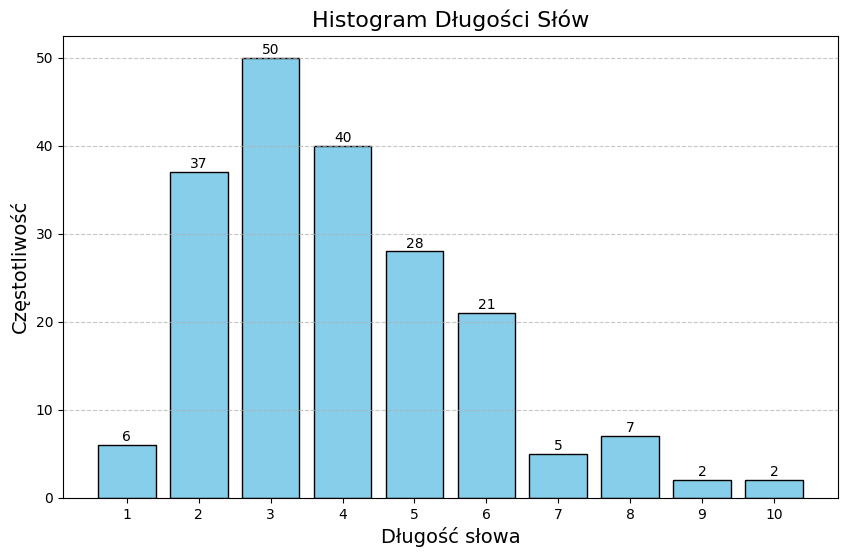

In [812]:
words_length_histogram(all_words)

### Unit Tests

In [813]:
import ipytest
import pytest

ipytest.autoconfig()  # integrate pytest with the notebook

test longest_words

In [820]:

@pytest.mark.parametrize(
    "text, n, expected",
    [
        ("Ala ma kota", 1, ["kota"]),
        ("Ala ma kota", 2, ["kota", "ala"]),
        ("Ala ma kota", 3, ["kota", "ala", "ma"]),
        ("To be, or not to be, that is the question.", 2, ["question", "that"])
    ],
)
def test_longest_words(text, n, expected):
    assert longest_words(text, n) == expected

test tokenize_by_regexp

In [815]:
tokenize = tokenize_by_regexp


@pytest.mark.parametrize(
    "text, expected",
    [
        ("123 abc", ["123", "abc"]),
        # skipping interpunction
        ("Ala ma kota, kot ma Alę!", ["ala", "ma", "kota", "kot", "ma", "alę"]),
        # other witespace characters
        ("123 abc\n456\tdef", ["123", "abc", "456", "def"]),
        # edge cases
        ("", []),
        ("   \t\n  ", []),
    ],
)
def test_tokenize(text, expected):
    assert tokenize(text) == expected

test most_common_words

In [816]:

@pytest.mark.parametrize(
    "text, n, expected",
    [
        ("world world world", 1, [('world', 3)]),
        ("world world world", 3, [('world', 3)]),
        ("world world world.", 4, [('world', 3)]),
        ("World WORLD, worLD!", 3, [('world', 3)]),
        ("Hello WORLD! Hello World, Hello Bob", 3, [('hello', 3), ('world', 2), ("bob", 1)]),

        ("", 3, []),
    ]
)
def test_most_common_words(text, n, expected):
    assert most_common_words(text, n) == expected

In [817]:
def test_cleanup_text():
    text = load_text('one-more-cup-of-coffee.txt')
    config = DEFAULT_CONFIG_EN
    cleaned_text = cleanup_text(text, config)

    assert "[Chorus]" not in cleaned_text
    assert "[Verse 1]" not in cleaned_text
    assert "[Verse 2]" not in cleaned_text

    # "the" is part of "annother"
    assert "another" in cleaned_text
    # the is removed as a separate word
    assert "the " not in cleaned_text

    assert "One more cup of coffee for  road" in cleaned_text

In [821]:
ipytest.run()

................                                                                             [100%]
16 passed in 0.02s


<ExitCode.OK: 0>